In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [4]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 110/110 [00:03<00:00, 35.14it/s]


In [5]:
X_train.shape

(3190, 224, 224, 3)

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=1010)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

Model Build

In [10]:
from tensorflow.keras.layers import Input, Conv2D, \
     MaxPool2D, Flatten, Dense

input = Input(shape=(224, 224, 3))

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(input)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(units=4096, activation='relu')(x)
x = Dense(units=4096, activation='relu')(x)
x = Dense(units=2, activation='softmax')(x)


In [11]:
# Create model.
inputs = input
model =  keras.Model(inputs, x, name='VGG16')
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

In [12]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')

In [13]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("VGG16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [14]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 450.6054 - accuracy: 0.5836
Epoch 1: val_accuracy improved from -inf to 0.59375, saving model to VGG16.h5
72/72 [==============================] - 64s 616ms/step - loss: 450.6054 - accuracy: 0.5836 - val_loss: 0.6854 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.5910
Epoch 2: val_accuracy did not improve from 0.59375
72/72 [==============================] - 31s 426ms/step - loss: 0.7262 - accuracy: 0.5910 - val_loss: 0.6816 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.5932
Epoch 3: val_accuracy did not improve from 0.59375

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
72/72 [==============================] - 31s 425ms/step - loss: 0.6772 - accuracy: 0.5932 - val_loss: 0.6755 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/20
72/72 [====

<ipython-input-15-93565f2ec6c2>:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
<ipython-input-15-93565f2ec6c2>:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


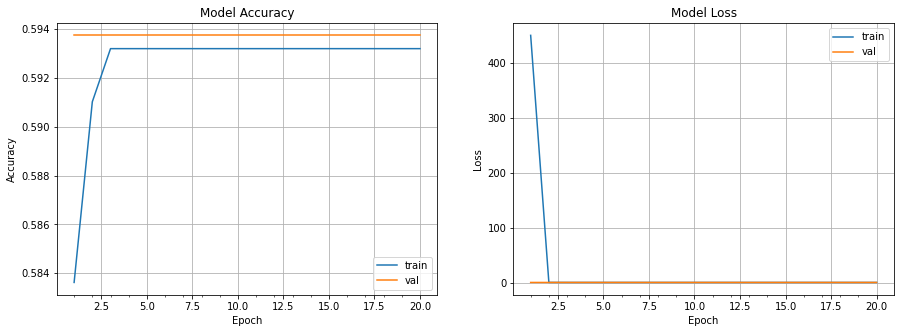

In [15]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].grid()
    
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].grid()
    plt.show()
    
plot_model_history(history)

In [16]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

20/20 [==============================] - 5s 258ms/step


In [17]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       396
           1       0.00      0.00      0.00       242

    accuracy                           0.62       638
   macro avg       0.31      0.50      0.38       638
weighted avg       0.39      0.62      0.48       638



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


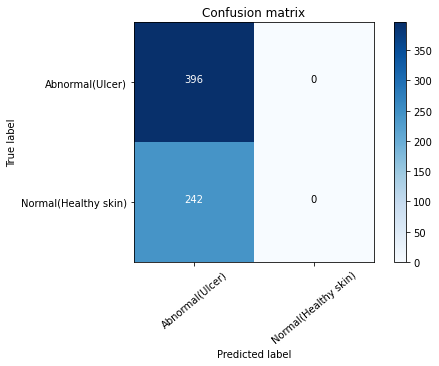

In [19]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,labels)
plt.savefig('VGG16NetCM',dpi=400)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.5f' % accuracy_score(y_test_new, pred), 'Precision: %.5f' % precision_score(y_test_new, pred),' Recall: %.5f' % recall_score(y_test_new, pred), 
      'F1 Score: %.5f' % f1_score(y_test_new, pred), 'AUC Score: %.5f' % roc_auc_score(y_test_new, pred))

Accuracy: 0.62069 Precision: 0.00000  Recall: 0.00000 F1 Score: 0.00000 AUC Score: 0.50000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [22]:
print('TP = %.5f'%TP, 'TN = %.5f'%TN, 'FP = %.5f'%FP, 'FN = %.5f'%FN)

TP = 0.00000 TN = 396.00000 FP = 0.00000 FN = 242.00000


In [23]:
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)

Specificity: 1.00000


In [24]:
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)

 Recall: 0.00000
 Precision: nan


<ipython-input-24-1313dfa97543>:3: RuntimeWarning: invalid value encountered in true_divide
  precision=TP/float(TP+FP)


In [25]:
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)

F1 Score: nan


In [26]:
print( 'AUC Score: %.5f' % roc_auc_score(y_test_new, pred))

AUC Score: 0.50000


In [27]:
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.5f' % mean_squared_error(y_test_new, pred))

Error Rate: 0.37931


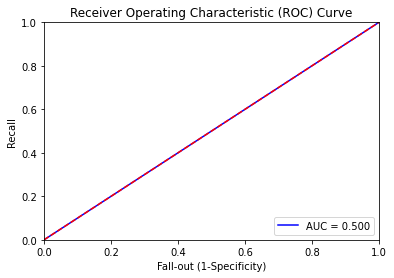

In [28]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.savefig('Covid_VGG16AUC',dpi=400)
plt.show()

In [29]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))
print('val_accuracy: {0:0.2f}%'.format(np.round((history.history['val_accuracy'][-1])*100, 2)))

Accuracy: 62.07%
Precision: nan%
Recall or Sensitivity: 0.00%
Specificity: 100.00%
F1-score: nan%
AUC-score: 50.00%
Train acc: 59.32%
val_accuracy: 59.38%


<ipython-input-29-4630c6fc23fa>:4: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)*100


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score
from scipy import interp
from itertools import cycle

<ipython-input-31-c78eae1ad4f5>:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


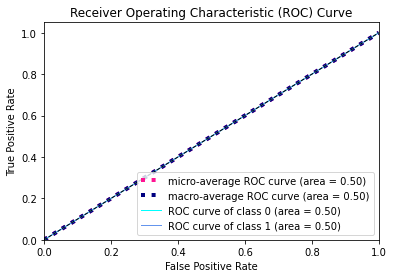

In [31]:
# Plot linewidth.
lw = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_new, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_new.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('Covid_VGG16_ROC',dpi=400)
plt.show()

In [32]:

import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.11.0


In [33]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import inception_v3 as inc_net
from skimage.io import imread
from skimage.transform import resize
import numpy as np 
from skimage import io
from skimage.transform import resize
import sklearn.cluster

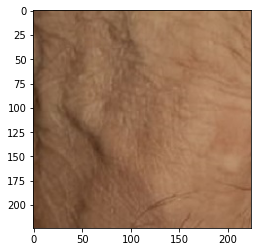

1/1 [==============================] - 0s 21ms/step
Normal(Healthy skin)
Accuracy: 59.28%


In [53]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU_dataset/check_model/Normal(Healthy skin)/image (115).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

if prediction == 1:
    print('Abnormal(Ulcer)')
else:
    print('Normal(Healthy skin)')
print('Accuracy: {0:0.2f}%'.format(pct*100))


In [35]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=65bbf42fbe57b3ed77ed0eb1213d4b511eacc343af653666cf6fb1930e9a0f9a
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [36]:
from lime import lime_image
explainer =lime_image.LimeImageExplainer()

In [54]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict, 
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


In [38]:
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt

(-0.5, 223.5, 223.5, -0.5)

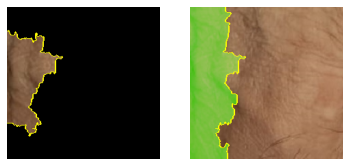

In [55]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

In [40]:
import skimage

In [56]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions
def transform_img_fn_ori(image):
  img = np.array(image)
  img=resize(img,(299,299))
  img=(img-0.5)*2
  img=np.expand_dims(img,axis=0)
  preds=inet_model.predict(img)
  for i in decode_predictions(preds)[0]:
    print(i)
  return img
inet_model=inc_net.InceptionV3()
images_inc_im=transform_img_fn_ori(image)

1/1 [==============================] - 1s 1s/step
('n02504458', 'African_elephant', 0.08359998)
('n02088466', 'bloodhound', 0.07072434)
('n03404251', 'fur_coat', 0.061472367)
('n04525038', 'velvet', 0.026508594)
('n01776313', 'tick', 0.024337986)


In [57]:
explanation = explainer.explain_instance(images_inc_im[0].astype('double'), #the image
                                         inet_model.predict, 
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         random_seed=42)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


(-0.5, 298.5, 298.5, -0.5)

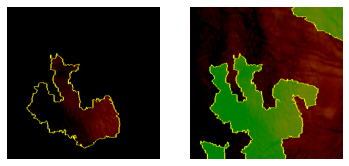

In [58]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

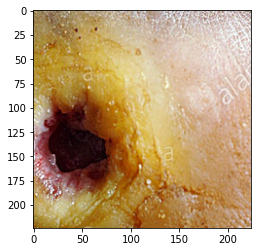

1/1 [==============================] - 0s 24ms/step
Normal(Healthy skin)
Accuracy: 59.28%


In [62]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU_dataset/check_model/Abnormal(Ulcer)/i (2).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

if prediction == 1:
    print('Abnormal(Ulcer)')
else:
    print('Normal(Healthy skin)')
print('Accuracy: {0:0.2f}%'.format(pct*100))


In [45]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict, 
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


(-0.5, 223.5, 223.5, -0.5)

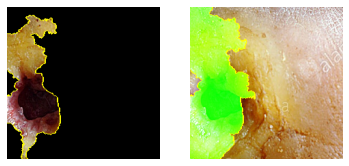

In [51]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

In [63]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions
def transform_img_fn_ori(image):
  img = np.array(image)
  img=resize(img,(299,299))
  img=(img-0.5)*2
  img=np.expand_dims(img,axis=0)
  preds=inet_model.predict(img)
  for i in decode_predictions(preds)[0]:
    print(i)
  return img
inet_model=inc_net.InceptionV3()
images_inc_im=transform_img_fn_ori(image)

1/1 [==============================] - 2s 2s/step
('n07745940', 'strawberry', 0.07370328)
('n07875152', 'potpie', 0.06794693)
('n07753113', 'fig', 0.047575705)
('n07693725', 'bagel', 0.041572716)
('n07584110', 'consomme', 0.041223437)


In [64]:
explanation = explainer.explain_instance(images_inc_im[0].astype('double'), #the image
                                         inet_model.predict, 
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         random_seed=42)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


(-0.5, 298.5, 298.5, -0.5)

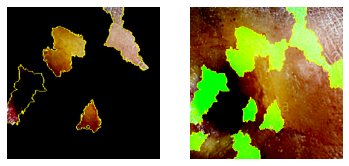

In [65]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')